In [1]:
# default_exp model

# FastBert for SemEval-2019 Task 3

> We are applying Bert to SemEval-2019 Task 3. See this article for the challenge setting: https://www.aclweb.org/anthology/S19-2005.pdf. We use the customization work from the notebook 00_fastbert to connect Bert with fast.ai (seperated sequences approach).

In [2]:
# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig

# fast.ai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# fastbert
from semeval2019_task3.fastbert import *

# dataloader utility function
from data_cleaner import process_pipeline

/home/phil/Projects/venv/consult/lib/python3.7/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


/home/phil/Projects/venv/consult/lib/python3.7/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [3]:
# for the other models from huggingfaces go to
# https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta
# notebook will work as well
# just pay attention at the customized model section

model_class, tokenizer_class, config_class = BertForSequenceClassification, BertTokenizer, BertConfig

In [4]:
# get the data as dataframes 
train = pd.read_csv('./data/train.txt', delimiter='\t', encoding='utf-8', index_col='id')
dev = pd.read_csv('./data/dev.txt', delimiter='\t', encoding='utf-8', index_col='id')
test = pd.read_csv('./data/test.txt', delimiter='\t', encoding='utf-8', index_col='id')

In [5]:
train.sample(5)

,turn1,turn2,turn3,label
id,,,,
2460,That's good. Respect everyone. Do not use slan...,u seem to be a software engineer... did u stop...,This language I always use but the abusive wor...,angry
975,ok. not sorry,I am sorry though.,ok,others
12247,Too much waiting...😡😡😡😠,I No Angry you. 😷😷,Its so irritating...,angry
17553,Damn,Lol. I don't need to check.,That's so sweet of you.,others
2671,Not fine,why..,I proposed you bt you denied,sad


In [6]:
# preprocessing steps for the turns
# for details check out the process_pipeline function
# we are not applying much preprocessing in order
# to keep the input as raw as possible for Bert
# just simple steps like smileys, all_caps, repeated words
# are handled as they differ more from the source used to pre-train Bert
# check out the original Bert paper for details
# https://arxiv.org/pdf/1810.04805v2.pdf
for turn in ['turn1', 'turn2', 'turn3']: 
    train[turn] = train[turn].apply(process_pipeline)
    dev[turn] = dev[turn].apply(process_pipeline)
    test[turn] = test[turn].apply(process_pipeline)

In [7]:
# lookup for labels
EMOS_DIC = {'happy': 0,
            'angry': 1,
            'sad': 2,
            'others': 3}

In [8]:
# make sure FastAi gets the order of labels for the special loss function
train.label = train.label.apply(lambda x: EMOS_DIC[x])
dev.label = dev.label.apply(lambda x: EMOS_DIC[x])
test.label = test.label.apply(lambda x: EMOS_DIC[x])

In [9]:
# export
def seed_all(seed_value=42):
    """random seeding Python and torch"""
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [10]:
seed_all()

In [11]:
# setting up the processors for fast.ai TextList 
pretrained_model_name = 'bert-large-uncased-whole-word-masking'

transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = SeqTokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])
tokenize_processor = SeqTokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

transformer_processor = [tokenize_processor, numericalize_processor]

In [12]:
# padding token
pad_idx = transformer_tokenizer.pad_token_id

In [13]:
# setting up the databunch
databunch = (TextList.from_df(train, cols=['turn1', 'turn2', 'turn3'], processor=transformer_processor)
             .split_none()
             .label_from_df(cols= 'label')
             .databunch(bs=32, pad_first=False, pad_idx=pad_idx))

In [14]:
# batchsizes have to be devidors of the length of the data 
# with TextList objects the last batch would be cut if not
# it would cut the last not size fitting batch out completly
# to validate on new data we have to create a dataloader
# most easiest way is to use the datablock api from FastAi

databunch.valid_dl = (TextList.from_df(dev, cols=['turn1', 'turn2', 'turn3'], processor=transformer_processor)
                      .split_none()
                      .label_from_df(cols= 'label')
                      .databunch(bs=5, pad_first=False, pad_idx=pad_idx)).train_dl

In [15]:
test_dl = (TextList.from_df(test, cols=['turn1', 'turn2', 'turn3'], processor=transformer_processor)
             .split_none()
             .label_from_df(cols= 'label')
             .databunch(bs=7, pad_first=False, pad_idx=pad_idx)).train_dl

## Model setup

In [16]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 4
config.use_bfloat16 = True # False
print(config)

{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "num_labels": 4,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": true,
  "vocab_size": 30522
}



In [17]:
# create the customized model from the pretrained Bert weights
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

## Loss and Metrices

As one can see in the article of the challenge we have a special requirement for the metrices. Also as the data is imbalanced it would be a good idea to reweight the loss function.

In [18]:
# the weights result from the balances of the train dataset
weight_list = [0.3198680179, 0.246494733, 0.2484349259, 1.74527696]
weight_label = torch.Tensor(weight_list).cuda()
loss_criterion = nn.CrossEntropyLoss(reduction='none')

In [19]:
# export
def loss_reweight(pred, y_b):
    """cross entropy loss with reweighting"""
    loss_label = loss_criterion(pred, y_b.view(-1).cuda()).cuda()
    loss_label = torch.matmul(torch.gather(weight_label, 0, y_b.view(-1).cuda()), loss_label) / \
                 y_b.view(-1).shape[0]

    return loss_label

Note that we are trying to maximize the micro-averaged F1 score for the three emotion classes - Happy, Sad and Angry. To be precise, the defined metric goes as follows:

\begin{equation*}
P_{\mu } = \frac{\sum T P_{i}}{\sum (T P_{i} + F P_{i})} \forall i \in \{ Happy, Sad, Angry \}
\end{equation*}

\begin{equation*}
R_{\mu } = \frac{\sum T P_{i}}{\sum (T P_{i} + F N_{i})} \forall i \in \{ Happy, Sad, Angry \}
\end{equation*}

With $T P_{i}$, $F P_{i}$, $F N_{i}$ are the true postives, false positives and false negatives of class $i$.




Hence we will write $F 1_{\mu}$ as a customized metric.

In [20]:
# export
def metrics(logits, labels):
    cm = torch.zeros((4,4))
    preds = torch.argmax(logits, dim=1)
    acc = (labels == preds).float().mean()
    for label, pred in zip(labels.view(-1), preds.view(-1)):
        cm[label.long(), pred.long()] += 1
        
    tp = cm.diagonal()[:3].sum()
    fp = cm[:, :3].sum() - tp
    fn = cm[:3, :].sum() - tp 
    return {'val_acc': acc, 'tp': tp, 'fp': fp, 'fn': fn}

def f1_score(tp, fp, fn):
    prec_rec_f1 = {}
    prec_rec_f1['precision'] = tp / (tp + fp)
    prec_rec_f1['recall'] = tp / (tp + fn)
    prec_rec_f1['f1_score'] = 2 * (prec_rec_f1['precision'] * prec_rec_f1['recall']) / (prec_rec_f1['precision'] + prec_rec_f1['recall'])
    return prec_rec_f1

Credits for the metrics: https://github.com/juliusberner/emotion_transformer/blob/master/01_model.ipynb

In [21]:
# export
class F1Micro(Callback):
    """custom loss for fast.ai"""
    def on_epoch_begin(self, **kwargs):
        self.out, self.target = torch.empty(0), torch.empty(0)
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        self.out = torch.cat((self.out.type(last_output.cpu().type()), last_output.cpu()))
        self.target = torch.cat((self.target.type(last_target.cpu().type()), last_target.cpu()))
    
    def on_epoch_end(self, last_metrics, **kwargs):
        assert self.out.shape[0] == self.target.shape[0]
        metric = metrics(self.out, self.target)
        f1_dict = f1_score(metric['tp'], metric['fp'], metric['fn'])
        return add_metrics(last_metrics, [f1_dict['f1_score'].numpy()] )

We also thought about mixup in the learner as data augumentation. For now we don't know how to apply it here as we have word level embeddings with three different turns what makes it from a logical standpoint in language not really usefull. We could shift the embeddings by a mean of the turn word embeddings of the shuffled version batch but that might lead also to no better results. So something one could experiment with :)

In [22]:
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, F1Micro()],
                  loss_func=loss_reweight,
                  callback_fns=partial(GradientClipping, clip=0.888))

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))
# learner.callbacks.append(SaveModelCallback(learner, every='improvement', monitor='valid_loss', name='best_model'))

# Put learn in FP16 precision mode
learner = learner.to_fp16() # delete the line if fp16 is not wanted

In [23]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [64, 1024]           31,254,528 True      
______________________________________________________________________
Embedding            [64, 1024]           524,288    True      
______________________________________________________________________
Embedding            [64, 1024]           2,048      True      
______________________________________________________________________
LayerNorm            [64, 1024]           2,048      True      
______________________________________________________________________
Dropout              [64, 1024]           0          False     
______________________________________________________________________
Linear               [64, 1024]           1,049,600  True      
______________________________________________________________________
Linear               [64, 1024]           1,049,600  True      
_______________________________________

In [24]:
learner.save('untrain')

In [25]:
seed_all() # make sure we have same seeds when rerunning
learner.load('untrain');

In [26]:
# With other examples of fast.ai combined with Bert models 
# we saw people trying to use the fast.ai version what is 
# also used in training ulmfit 
# Namely unfreezing the model layer-by-layer 
# One has to keep in mind that this is a good practice 
# for ulmfit but not for Bert models 
# When fine tuning ulmfit there is a first phase of fine-tuning 
# the models langauge model to adapt to the specific language in 
# the training data 
# Then a fine-tuning in classification takes place
# With bert the fine-tuning of the language and classification 
# takes place simultane
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-04
Min loss divided by 10: 1.32E-03


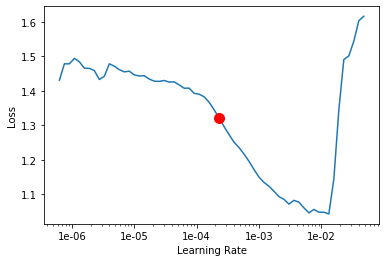

In [28]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,f1_micro,time
0,0.209308,0.205090,0.923049,0.747452,05:43
1,0.147107,0.233982,0.924501,0.758545,05:43


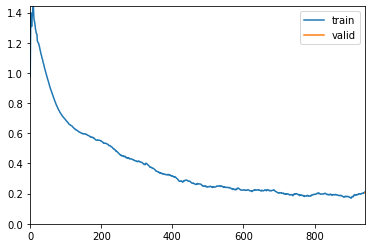

In [29]:
# -- results of manual hyperparameter search --

# Note that in this challenge it was allowed to validate
# on the test data in the last phase of the challenge
# as the data is really messy one has to be extra cautious

# ---------------------------------------------

# f1_micro_test 74.8% - (2, 1e-04, (0.9,0.8)) - overfitting on train dataset
# f1_micro_test 75.14% - (2, 1e-04, (0.8,0.7))
# f1_micro_test 75.21% - (3, 1e-04, (0.8,0.7))
# f1_micro_test 75.3% - (2, 1.25e-04, (0.85,0.75))
# f1_micro_test 75.5% - (2, 1.1e-04, (0.85,0.75))
# f1_micro_test 75.6% - (3, 1.1e-04, (0.85,0.75))
# f1_micro_test 75.67% - (2, 0.94e-05, (0.85,0.75))
# f1_micro_test 75.9% (val: 76.52%) - (2, 0.8e-04, (0.85,0.75))
# f1_micro_test 76.01% - (2, 1e-04, (0.85,0.75))
# f1_micro_test 76.21% - (2, 0.98e-04, (0.85,0.75)), (2, 0.95e-04, (0.85,0.75))

# ---------------------------------------------


learner.fit_one_cycle(2, max_lr=1e-04, moms=(0.85,0.75))

In [30]:
# validation on the dev dataset
learner.validate(databunch.valid_dl)

[0.23397401, tensor(0.9245), array(0.758545, dtype=float32)]

In [31]:
# validation on the test dataset
learner.validate(test_dl)

[0.23983945, tensor(0.9225), array(0.749302, dtype=float32)]

## Conclusion

We reached scores ranking in the top 3% for the challenge, by just using simple Bert and one cycle learning. With the customization work it is now possible to try out multiple new techniques of fast.ai to get even better scores.

Just to name a few: Discriminative Fine-tuning, Gradual unfreezing, LabelSmoothing, MixUp, …

In [1]:
from nbdev.export import *
notebook2script()

Converted 00_fastbert.ipynb.
Converted 01_task3.ipynb.
Converted index.ipynb.
